# 💡 What's new in txtai 7.0

txtai 7.0 brings a number of major feature enhancements. Highlights include:

- Semantic Graph 2.0
  - Graph search
  - Advanced graph traversal
  - Graph RAG

- Embeddings
  - Default configuration format now JSON
  - Move ids storage outside of configuration when content is disabled

- Pipelines
  - Training support for LoRA / QLoRA

- API
  - Binary transport support

These are just the big, high level changes. There are also many improvements and bug fixes.

This notebook will cover all the changes with examples.

**Standard upgrade disclaimer below**

While everything is backwards compatible, it's prudent to backup production indexes before upgrading and test before deploying.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[api,graph,pipeline-train] datasets autoawq

# Semantic Graph 2.0

The biggest change and reason this is a major release is the addition of a number of new graph-driven patterns. Let's jump right into with that.

## Graph search

The first feature we'll test out is running a search that returns results as a graph. With this change, not only do we get search results, we get how these search results relate to each other.

We'll use a [prompt dataset on the Hugging Face Hub](https://huggingface.co/datasets/fka/awesome-chatgpt-prompts) for all examples.

In [ ]:
from datasets import load_dataset

import txtai

# Load dataset
ds = load_dataset("fka/awesome-chatgpt-prompts", split="train")

def stream():
  for row in ds:
    yield (row["act"], f"{row['act']} {row['prompt']}")

# Build sparse keyword index
embeddings = txtai.Embeddings(content=True, graph={"approximate": False})
embeddings.index(stream())

graph = embeddings.search("Linux terminal", 5, graph=True)

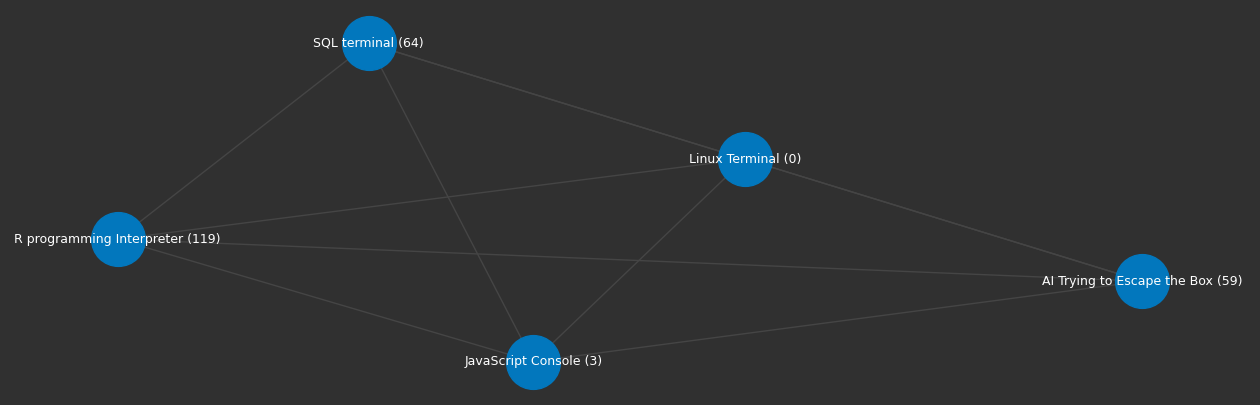

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')} ({x})" for x in graph.scan()}
    options = {
        "node_size": 1500,
        "node_color": "#0277bd",
        "edge_color": "#454545",
        "font_color": "#fff",
        "font_size": 9,
        "alpha": 1.0
    }

    fig, ax = plt.subplots(figsize=(16, 5))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

    plt.show()

plot(graph)

We now see a graph of not only the search results but how they relate to each other!

## Advanced graph traversal

Before 7.0, the main way to traverse a graph was via the `showpath` method. This method finds the shortest path between two graph nodes. What if we want more control over how a path is traversed? Enter advanced graph traversal.

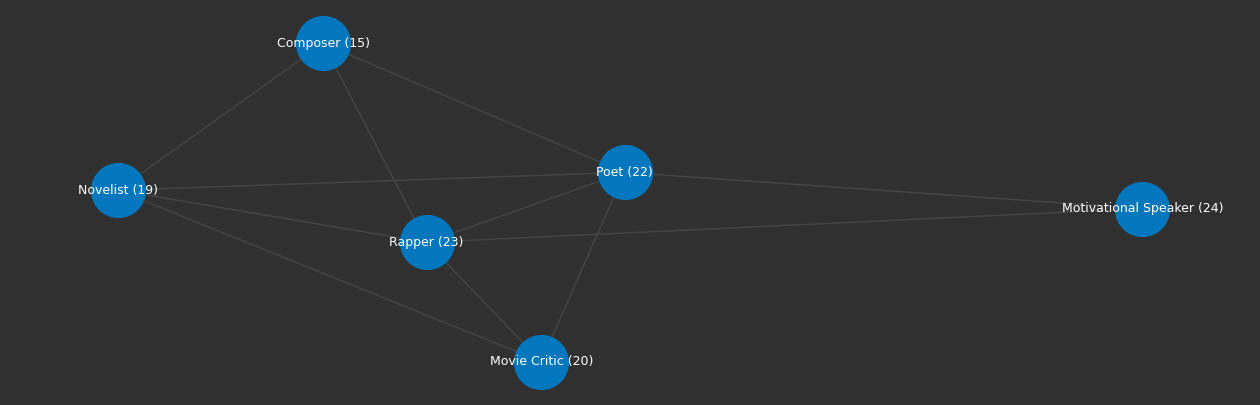

In [ ]:
g = embeddings.graph.search("""
MATCH P=({id: "Poet"})-[*1..2]->({id: "Rapper"})
RETURN P
LIMIT 5
""", graph=True)

plot(g)

The query above finds the top 5 connections between a `Poet` and a `Rapper` using a graph query. Graph queries use the [openCypher](https://github.com/opencypher/openCypher) query standard.

## Graph RAG

Graph path traversal opens up a different type of RAG process. A standard RAG process typically runs a single vector search query and returns the closest matches. Those matches are then passed into a LLM prompt and used to limit the context and help ensure more factually correct answers are generated. Graphs enable more complex analysis.

We'll use the graph path from the previous example for a more complex RAG query.

In [ ]:
from txtai import LLM

llm = LLM("TheBloke/Mistral-7B-OpenOrca-AWQ")

def rag(question, text):
    prompt = f"""<|im_start|>system
    You are a friendly assistant. You answer questions from users.<|im_end|>
    <|im_start|>user
    Answer the following question using only the context below. Only include information specifically discussed.

    question: {question}
    context: {text} <|im_end|>
    <|im_start|>assistant
    """

    return llm(prompt, maxlength=4096)

context = "\n".join(g.attribute(node, "text") for node in list(g.scan()))

print(rag("What roles are similar to both a rapper and poet?", context))


The roles that are similar to both a rapper and poet are:

1. Composer: A composer creates music for various forms of art, including songs and poems. They work with different instruments and tools to bring the lyrics to life, making the music harmonious and engaging.

2. Novelist: A novelist creates captivating stories with engaging characters and plotlines. They can write in various genres, such as science fiction, romance, or historical fiction. The goal is to write a story that keeps readers engaged and entertained.

3. Movie Critic: A movie critic evaluates and reviews movies, discussing aspects like plot, themes, acting, direction, and more. They aim to express their feelings about the movie and how it impacted them, while also providing constructive criticism.

4. Motivational Speaker: A motivational speaker inspires and empowers their audience by sharing words of wisdom and encouragement. They can talk about various topics, but the goal is to make their audience feel motivated a

Let's compare these results with the results from a standard RAG query. We'll pull the 6 most similar rows to have the same sized dataset as what is in the graph above.

In [ ]:
question = "What roles are most similar role to both a rapper and poet?"
context = "\n".join(x["text"] for x in embeddings.search(question, limit=6))
print(rag(question, context))

The roles most similar to both a rapper and poet are the Composer and the Song Recommender. Both roles involve creating music or recommending songs based on given lyrics or themes.


As we can see, the Graph RAG approach yields a more comprehensive answer. The standard RAG answer isn't bad, it's just not as complete.

# Embeddings

There are a couple backwards compatible changes to the embeddings database format. The default configuration format moving forward is `json`. While `pickle` configuration is still supported, txtai is moving towards a readable configuration format. This is to have maximum compatability with the Hugging Face Hub, when uploading models. The `pickle` format is generally not recommended when sharing indexes.

In [ ]:
import json
import pickle

from txtai import Embeddings

# Create a default index
embeddings = Embeddings()
embeddings.index(["test1", "test2"])
embeddings.save("index")

# Read standard configuration
with open("index/config.json") as f:
    print(json.dumps(json.load(f), sort_keys=True, default=str, indent=2))

# Read ids
with open("index/ids", "rb") as f:
    print("ID List:", pickle.load(f))

{
  "autoid": 2,
  "backend": "faiss",
  "build": {
    "create": "2024-02-21T16:23:26Z",
    "python": "3.8.18",
    "settings": {
      "components": "IDMap,Flat"
    },
    "system": "Linux (x86_64)",
    "txtai": "7.0.0"
  },
  "dimensions": 384,
  "offset": 2,
  "path": "sentence-transformers/all-MiniLM-L6-v2",
  "update": "2024-02-21T16:23:26Z"
}
ID List: [0, 1]


When no configuration is specified, notice that a `config.json` file is created along with an `ids` file. Ids are no longer stored within the configuration both for `json` and `pickle` configuration. When loading an existing index, the ids are automatically read and moved when saving a new version.

# LoRA / QLoRA support

Two new parameters have been added to the `HFTrainer` pipeline, `lora` and `quantize`. When both of those are enabled, models are trained using QLoRA. Custom settings are also supported.

In [ ]:
from txtai.pipeline import HFTrainer

trainer = HFTrainer()
model, _ = trainer(
    "ahxt/LiteLlama-460M-1T",
    [{"label": 0, "text": "sample text"}],
    maxlength=16,
    task="language-generation",
    quantize=True,
    lora=True,
)

trainable params: 8,355,840 || all params: 470,041,600 || trainable%: 1.7776809541963945


  0%|          | 0/3 [00:00<?, ?it/s]

{'train_runtime': 0.3832, 'train_samples_per_second': 7.829, 'train_steps_per_second': 7.829, 'train_loss': 9.008923212687174, 'epoch': 3.0}


# Binary transport support

The API added support for reading and writing binary content. These changes will be pushed to the API clients in a future release. These changes include:

- Images and media content
- Encoding binary JSON and using MessagePack

In [ ]:
%%writefile index.yml

embeddings:

Overwriting index.yml


In [ ]:
!CONFIG=index.yml nohup uvicorn "txtai.api:app" &> api.log &
!sleep 90

In [ ]:
import requests

requests.post("http://localhost:8000/add", json=["test"])
requests.get("http://localhost:8000/index")

print(requests.get("http://localhost:8000/count", headers={"Accept": "application/json"}).content)
print(requests.get("http://localhost:8000/count", headers={"Accept": "application/msgpack"}).content)

b'0'
b'\x00'


Notice the subtle but important difference between the two outputs. The first response is a `0` character as JSON. The second response is the `\x00` character and can be intrepreted as a `0` using MessagePack. See below.

In [ ]:
import msgpack
print(msgpack.loads(requests.get("http://localhost:8000/count", headers={"Accept": "application/msgpack"}).content))

0


# Wrapping up

This notebook gave a quick overview of txtai 7.0. Updated documentation and more examples will be forthcoming. There is much to cover and much to build on!

See the following links for more information.

- [7.0 Release on GitHub](https://github.com/neuml/txtai/releases/tag/v7.0.0)
- [Documentation site](https://neuml.github.io/txtai)